In [1]:
%cd /home/soda/rcappuzz/work/prepare-data-lakes/

/home/soda/rcappuzz/work/prepare-data-lakes


In [2]:

import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import polars as pl
from pathlib import Path
import numpy as np
import re
import src.yago.utils as utils
import src.plotting.plotting_utils as plotting_utils
import os


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
pattern = r"(yago_seltab_<)([a-zA-Z_]+)[_0-9]*>"
replacement = r"\g<2>"
def clean_keys(type_name):
    return re.sub(pattern, replacement, type_name)

In [5]:
re.sub(pattern, replacement, "yago_seltab_<wikicat_Living_people>")

'wikicat_Living_people'

# Profile tables

## Profile Type tables

In [6]:
src_path = Path("data/yago3-dl/wordnet/")

In [7]:
tab_paths = list(src_path.iterdir())
first_tab = pl.read_parquet(tab_paths[0])

In [8]:
tab_paths

[PosixPath('data/yago3-dl/wordnet/yago_wordnet_album.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_song.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_administrative_district.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_building.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_person.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_company.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_movie.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_site.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_event.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_season.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_school.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_feature.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_station.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_book.parquet'),
 PosixPath('data/yago3-dl/wordnet/yago_wordnet_artist.parquet'),
 PosixPath('

In [9]:
tabs = {}
for tpath in tab_paths:
    if tpath.is_dir():
        continue
    tname = tpath.stem
    tab = pl.read_parquet(tpath)
    tabs[tname] = tab


In [10]:
list(tabs.keys())

['yago_wordnet_album',
 'yago_wordnet_song',
 'yago_wordnet_administrative_district',
 'yago_wordnet_building',
 'yago_wordnet_person',
 'yago_wordnet_company',
 'yago_wordnet_movie',
 'yago_wordnet_site',
 'yago_wordnet_event',
 'yago_wordnet_season',
 'yago_wordnet_school',
 'yago_wordnet_feature',
 'yago_wordnet_station',
 'yago_wordnet_book',
 'yago_wordnet_artist',
 'yago_wordnet_scientist',
 'yago_wordnet_commune',
 'yago_wordnet_officeholder',
 'yago_wordnet_writer',
 'yago_wordnet_river']

# Slicing tables

In [12]:
from itertools import combinations

In [13]:
def explode_table(tgt_table, table_name, dir_path, comb_size=2, min_occurrences=100):
    subdir_path = Path(dir_path, table_name)
    os.makedirs(subdir_path, exist_ok=True)
    # Ignore columns `type` and `subject` 
    target_columns = tgt_table.columns[2:]
    coords_dict = {}
    
    # Counting the number of non-null occurrences for each combination of size `comb_size`
    for comb in combinations(target_columns, comb_size):
        tt=tgt_table.select(
                pl.all(pl.col(comb).is_not_null())
            ).sum().item()
        coords_dict[comb] = tt

    df_coord = pd.DataFrame().from_dict(coords_dict, orient='index', columns=["count"])
    df_coord = df_coord.reset_index()

    # selecting only combinations with more than `min_occurrences` occs
    rich_combs = df_coord[df_coord["count"]>=min_occurrences]

    # For each comb, write a new parquet file. 
    for _, comb in rich_combs.iterrows():
        sel_col = ["type", "subject"] + list(comb["index"])
        res = tgt_table.filter(
            pl.all(pl.col(comb["index"]).is_not_null())
        ).select(pl.col(sel_col)).unique()
        
        filename = "_".join(table_name.split("_")[2:]) + "_" + "_".join(comb["index"])
        dest_path = Path(subdir_path, filename + ".parquet")
        print(dest_path)
        res.write_parquet(dest_path)


In [16]:
tabs.keys()

dict_keys(['yago_wordnet_album', 'yago_wordnet_song', 'yago_wordnet_administrative_district', 'yago_wordnet_building', 'yago_wordnet_person', 'yago_wordnet_company', 'yago_wordnet_movie', 'yago_wordnet_site', 'yago_wordnet_event', 'yago_wordnet_season', 'yago_wordnet_school', 'yago_wordnet_feature', 'yago_wordnet_station', 'yago_wordnet_book', 'yago_wordnet_artist', 'yago_wordnet_scientist', 'yago_wordnet_commune', 'yago_wordnet_officeholder', 'yago_wordnet_writer', 'yago_wordnet_river'])

In [17]:
tab_name = "yago_wordnet_person"
test_table = tabs[tab_name]

In [18]:
dir_path=Path("data/yago3-dl/wordnet/subtabs")
os.makedirs(dir_path, exist_ok=True)

False

In [19]:
explode_table(tab, tab_name, dir_path=dir_path, comb_size=2, min_occurrences=100)

data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_isLocatedIn_hasLength.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_isLocatedIn_wasCreatedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_isLocatedIn_hasLongitude.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_isLocatedIn_hasLatitude.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_isLocatedIn_wasDestroyedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_hasLength_wasCreatedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_hasLength_hasLongitude.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_hasLength_hasLatitude.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_hasLength_wasDestroyedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_wasCreatedOnDate_hasLongitude.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_person/person_wasCreatedOnDate_hasLatitude.pa

In [20]:
for tab_name, tab in tabs.items():
    explode_table(tab, tab_name, dir_path=dir_path, comb_size=2, min_occurrences=100)

data/yago3-dl/wordnet/subtabs/yago_wordnet_album/album_wasCreatedOnDate_hasDuration.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_album/album_wasCreatedOnDate_happenedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_album/album_wasCreatedOnDate_isLocatedIn.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_album/album_wasCreatedOnDate_wasDestroyedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_administrative_district/administrative_district_hasArea_hasWonPrize.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_administrative_district/administrative_district_hasArea_wasDestroyedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_building/building_hasLongitude_isConnectedTo.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_building/building_hasLongitude_isLocatedIn.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_building/building_hasLongitude_wasCreatedOnDate.parquet
data/yago3-dl/wordnet/subtabs/yago_wordnet_building/building_hasLongitude_wasDestroyedOn

In [21]:
# Considering all columns except for type and subject
target_columns = test_table.columns[2:]

In [22]:
# Evaluating all pairs of columns %
coords_dict = {}
for pair in combinations(target_columns, 2):
    c1, c2= pair
    tt=test_table.select(
        ((pl.col(c1).is_not_null()) & 
         (pl.col(c2).is_not_null()) 
         ).sum(),
    ).item()
    coords_dict[pair] = tt

In [23]:
df_coord = pd.DataFrame().from_dict(coords_dict, orient='index', columns=["count"])
df_coord = df_coord.reset_index()
df_coord[["left", "right"]]= df_coord["index"].to_list()
df_coord = df_coord[["left", "right", "count"]]

In [24]:
ranking = df_coord.sort_values("count", ascending=False)
ranking[ranking["count"]>100]

,left,right,count
8,created,wroteMusicFor,1694385
0,created,hasMusicalRole,954638
19,hasMusicalRole,wroteMusicFor,865517
5,created,influences,123256
26,isInterestedIn,influences,35103
1,created,isInterestedIn,32552
6,created,isLeaderOf,23842
59,influences,wroteMusicFor,19404
50,worksAt,influences,17291
4,created,worksAt,15875


<AxesSubplot: title={'center': 'Frequency of co-occurrence of predicate pairs in frequent values'}>

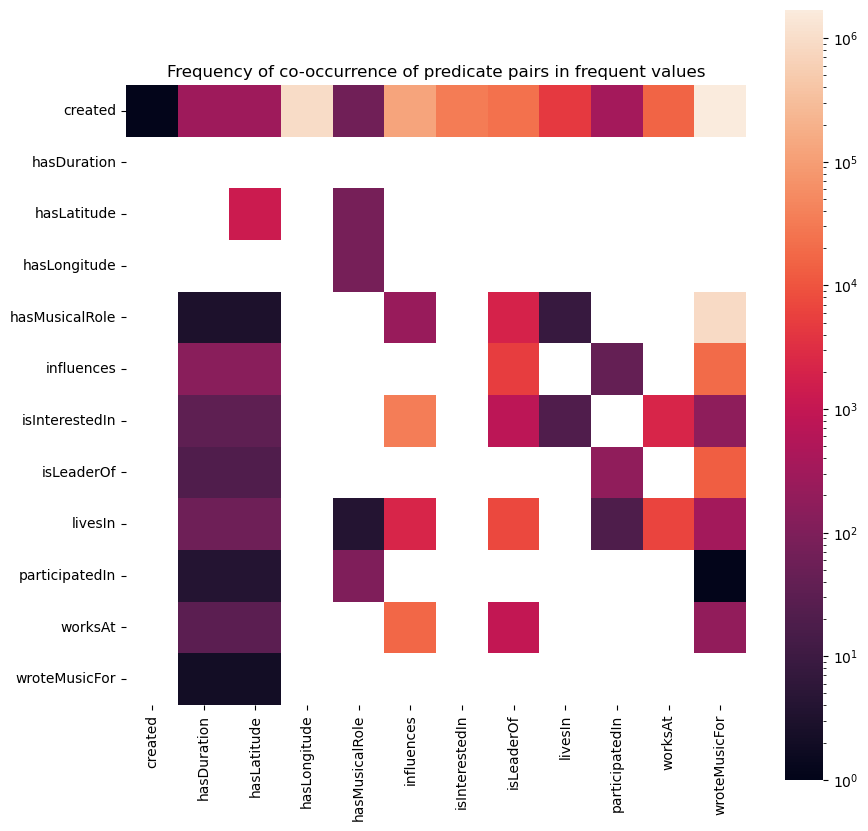

In [25]:
plotting_utils.plot_pairwise_heatmap(df_coord, lognorm=True)

In [26]:
# Evaluating all triplets
coords_dict = {}
for comb in combinations(target_columns, 3):
    c1, c2, c3 = comb
    tt=test_table.select(
        ((pl.col(c1).is_not_null()) & 
         (pl.col(c2).is_not_null()) &
         (pl.col(c3).is_not_null()) 
         ).sum(),
    ).item()
    coords_dict[comb] = tt
df_coord = pd.DataFrame().from_dict(coords_dict, orient='index', columns=["count"])
df_coord = df_coord.reset_index()
rich_triplets = df_coord[df_coord["count"]>=100]

In [27]:
for idx,triplet in rich_triplets.iterrows():
    sel_col = ["type", "subject"] + list(triplet["index"])
    res = test_table.filter(
        pl.all(pl.col(triplet["index"]).is_not_null())
    ).select(pl.col(sel_col)).unique()
